# Stochastic Partial Derivative Equations

<!-- SUMMARY: Estimation and Simulations performed in the framework of SPDE -->

<!-- CATEGORY: SPDE -->

In this tutorial, we show how to use the SPDE. We compare some calculations performed *by hand* with the results obtained through gstlearn API interfaces. Note that we also consider (probably temporarily) the Old interface (instantiating the SPDE class and performing subsequent calculations within this class) and the new interface where individual functions are designed for Kriging, Simulating and calculating LogLikelihood.

In [1]:
import gstlearn as gl
import gstlearn.plot as gp
import gstlearn.document as gdoc
import numpy as np
import matplotlib.pyplot as plt

from sksparse.cholmod import cholesky
import scipy as sc
from scipy.sparse import *
from scipy.sparse.linalg import *
import numpy as np

gdoc.setNoScroll()

<IPython.core.display.Javascript object>

## Parameters

In [2]:
# Data
np.random.seed(123)
ndat = 1000

# Model
rangev = 0.2
sill = 1.
nugget = 0.1

# Grid 
nx = [50,50]
dx = [0.02,0.02]
x0 = [0,0]

#Grid meshing
nxm = [75,75]
dxm = [0.02,0.02]
x0m = [-0.25,-0.25]

dbfmt = gl.DbStringFormat.createFromFlags(flag_stats=True, names=["spde*"])

### Grid and Meshing

In [3]:
grid = gl.DbGrid.create(nx,dx,x0)
gridExt = gl.DbGrid.create(nxm,dxm,x0m)
mesh = gl.MeshETurbo(gridExt)

### Model

In [4]:
model = gl.Model.createFromParam(gl.ECov.MATERN,param=1,range=rangev,sill=sill)
model.addCovFromParam(gl.ECov.NUGGET,sill=nugget)
model.setDriftIRF()

In [5]:
model


Model characteristics
Space dimension              = 2
Number of variable(s)        = 1
Number of basic structure(s) = 2
Number of drift function(s)  = 1
Number of drift equation(s)  = 1

Covariance Part
---------------
Matern (Third Parameter = 1)
- Sill         =      1.000
- Range        =      0.200
- Theo. Range  =      0.058
Nugget Effect
- Sill         =      0.100
Total Sill     =      1.100

Drift Part
----------
Universality_Condition

### Data

In [6]:
dat = gl.Db.create()
dat["x"] = np.random.uniform(size=ndat)
dat["y"] = np.random.uniform(size=ndat)
dat.setLocators(["x","y"],gl.ELoc.X)

## SPDE non-conditional simulation

### Grid query

In [7]:
spde = gl.SPDE(model,grid,None,gl.ESPDECalcMode.SIMUNONCOND)
gl.law_set_random_seed(131351)
iuid = spde.compute(grid)
grid.display(dbfmt)


Data Base Grid Characteristics

Data Base Summary
-----------------
File is organized as a regular grid
Space dimension              = 2
Number of Columns            = 4
Total number of samples      = 2500

Grid characteristics:
---------------------
Origin :      0.000     0.000
Mesh   :      0.020     0.020
Number :         50        50

Data Base Statistics
--------------------
4 - Name spde - Locator z1
 Nb of data          =       2500
 Nb of active values =       2500
 Minimum value       =     -3.342
 Maximum value       =      3.300
 Mean value          =     -0.121
 Standard Deviation  =      1.007
 Variance            =      1.014

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = x1 - Locator = x1
Column = 2 - Name = x2 - Locator = x2
Column = 3 - Name = spde - Locator = z1


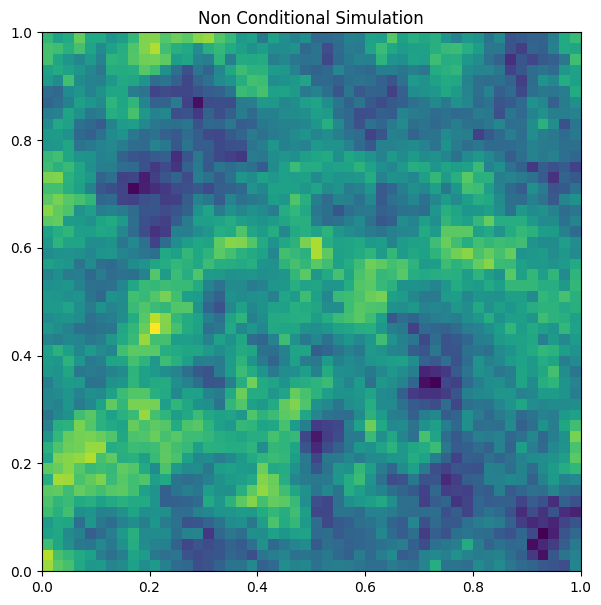

In [8]:
gp.init(figsize=[7,7],flagEqual=True)
gp.raster(grid)
gp.decoration(title="Non Conditional Simulation")

### Data query

In [9]:
gl.law_set_random_seed(131351)
iuid = spde.compute(dat)
dat.display(dbfmt)


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of Columns            = 3
Total number of samples      = 1000

Data Base Statistics
--------------------
3 - Name spde - Locator z1
 Nb of data          =       1000
 Nb of active values =       1000
 Minimum value       =     -2.993
 Maximum value       =      2.428
 Mean value          =     -0.157
 Standard Deviation  =      1.014
 Variance            =      1.028

Variables
---------
Column = 0 - Name = x - Locator = x1
Column = 1 - Name = y - Locator = x2
Column = 2 - Name = spde - Locator = z1


## Kriging

In [10]:
spdeRes = gl.SPDE(model,grid,dat,gl.ESPDECalcMode.KRIGING,mesh,1)
iuid = spdeRes.compute(grid)
grid.display(dbfmt)


Data Base Grid Characteristics

Data Base Summary
-----------------
File is organized as a regular grid
Space dimension              = 2
Number of Columns            = 5
Total number of samples      = 2500

Grid characteristics:
---------------------
Origin :      0.000     0.000
Mesh   :      0.020     0.020
Number :         50        50

Data Base Statistics
--------------------
4 - Name spde - Locator NA
 Nb of data          =       2500
 Nb of active values =       2500
 Minimum value       =     -3.342
 Maximum value       =      3.300
 Mean value          =     -0.121
 Standard Deviation  =      1.007
 Variance            =      1.014
5 - Name spde.spde.estim - Locator z1
 Nb of data          =       2500
 Nb of active values =       2500
 Minimum value       =     -2.554
 Maximum value       =      2.025
 Mean value          =     -0.137
 Standard Deviation  =      0.885
 Variance            =      0.783

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - 

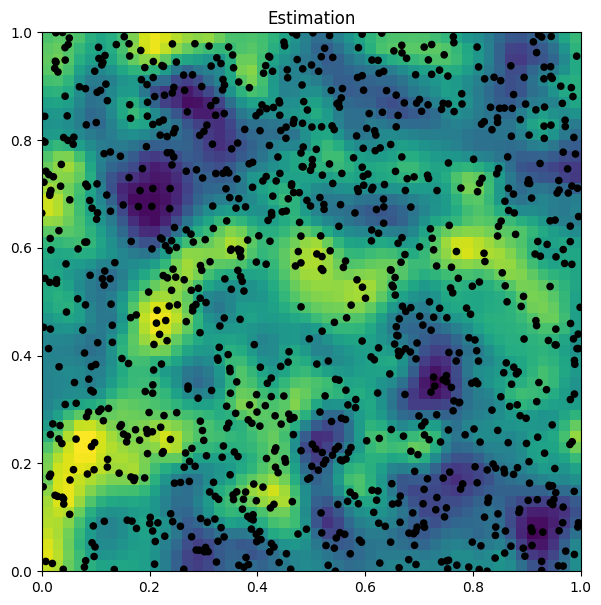

In [11]:
gp.init(figsize=[7,7],flagEqual=True)
gp.raster(grid)
gp.symbol(dat, c='black')
gp.decoration(title="Estimation")

## Manually

### Projection Matrix: mesh to grid

In [12]:
Pglg = gl.ProjMatrix(grid,mesh)
Aprojg = Pglg.toTL()

### Simulation

In [13]:
Q = spdeRes.getPrecisionOpMatrix().getQ().toTL()
cholQ = cholesky(Q)

Variance = 1.1733


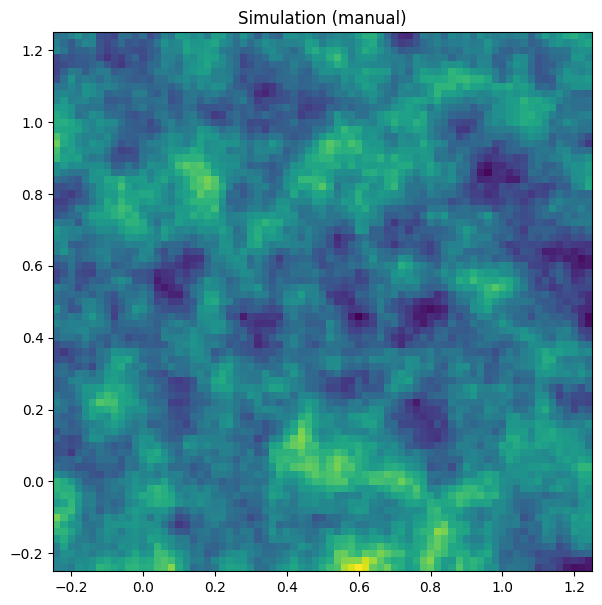

In [14]:
u = np.random.normal(size = Q.shape[0])
gridExt["simuManual"] = cholQ.apply_Pt(cholQ.solve_Lt(1./np.sqrt(cholQ.D())*u))
gridExt.addSelection((gridExt["x1"]>0) & (gridExt["x2"]>0) & (gridExt["x1"]<1.) & (gridExt["x2"]<1.))

gp.init(figsize=[7,7],flagEqual=True)
gp.raster(gridExt, "simuManual", useSel=False)
gp.decoration(title="Simulation (manual)")
print(f"Variance = {round(np.var(gridExt['simuManual'][np.where(gridExt['NewSel']==1)]),4)}")

### Kriging

In [15]:
Pgl = gl.ProjMatrix(dat,mesh)
Aproj = Pgl.toTL()

Qop = Q + 1/nugget * Aproj.T @ Aproj
cholQop =  cholesky(Qop)

kriging = cholQop.solve_A(Aproj.T @ (dat["spde*"]/nugget))
grid["manually"] = Aprojg @ kriging

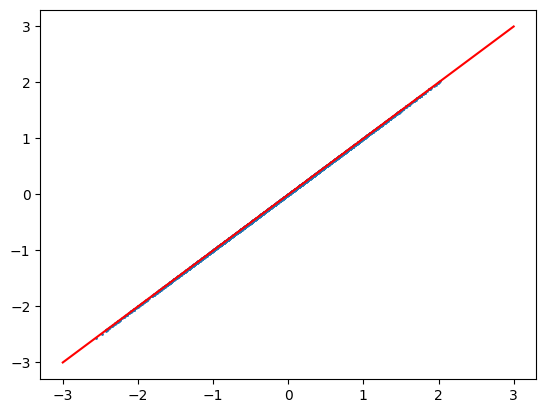

In [16]:
ax = plt.scatter(grid["manually"],grid["*estim"],s=1)
p = plt.plot([-3,3],[-3,3],c="r")

## Likelihood

Manually with Cholesky vs. matrix-free approach with SPDE api.

In [17]:
def solveMat(cholQop,x):
    return cholQop.solve_A(x)

def invSigma(sigma2,Aproj,cholQop,x):
    return 1./sigma2 * (x - 1./sigma2 * Aproj @ solveMat(cholQop, Aproj.T @ x))

def detQ(cholQ):
    return cholQ.logdet()

x = dat["spde"]
ones = np.ones_like(x)
invSigmaOnes = invSigma(nugget,Aproj,cholQop,ones)
mu  = np.sum(x * invSigmaOnes) / np.sum(ones * invSigmaOnes) 
nMC = 100
print(f"Value for MU = {round(mu,4)}")

Value for MU = -0.063


In [18]:
a_quad = np.sum((x-mu)*invSigma(nugget,Aproj,cholQop,x-mu))
b_quad = spdeRes.computeQuad()
print(f"Quadratic (manual)  = {round(a_quad,4)}")
print(f"Quadratic (api-old) = {round(b_quad,4)}")
print(f"-> Relative difference quadratic = {round(100*(b_quad - a_quad) / a_quad,2)}%")

Quadratic (manual)  = 1118.4871
Quadratic (api-old) = 1118.4871
-> Relative difference quadratic = 0.0%


In [19]:
a_op = detQ(cholQop)
b_op = spdeRes.getPrecisionKrig().computeLogDetOp(1)
print(f"log_det_op (manual)  = {round(a_op,4)}")
print(f"log_det_op (api-old) = {round(b_op,4)}")
print(f"-> Relative difference = {round(100*(b_op-a_op)/a_op, 2)}%")

log_det_op (manual)  = 12296.9389
log_det_op (api-old) = 12296.9389
-> Relative difference = 0.0%


In [20]:
a_one = detQ(cholQ)
b_one = spdeRes.getPrecisionKrig().computeLogDetQ(10)
print(f"log_det_Q (manual)  = {round(a_one,4)}")
print(f"log_det_Q (api-old) = {round(b_one,4)}")
print(f"-> Relative difference = {round(100*(b_one-a_one)/a_one,2)}%")

log_det_Q (manual)  = 11255.7151
log_det_Q (api-old) = 11255.7151
-> Relative difference = 0.0%


### Comparing the different outputs

- Manual calculation

In [21]:
logdetnoise = len(x) * np.log(nugget)
logdet = a_op - a_one + logdetnoise
a = -0.5 * (a_quad + logdet + len(x) * np.log(2. * np.pi))
print("Likelihood calculation (manual):")
print(f"log_det_op      = {round(a_op,4)}")
print(f"log_det_Q       = {round(a_one,4)}")
print(f"log_det_Noise   = {round(logdetnoise,4)}")
print(f"log_determinant = {round(logdet,4)}")
print(f"Quadratic term  = {round(a_quad,4)}")
print(f"-> Likelihood (manual) = {round(a,4)}")

Likelihood calculation (manual):
log_det_op      = 12296.9389
log_det_Q       = 11255.7151
log_det_Noise   = -2302.5851
log_determinant = -1261.3613
Quadratic term  = 1118.4871
-> Likelihood (manual) = -847.5015


- Using the old API 

In [22]:
spdeLL = gl.SPDE(model,grid,dat,gl.ESPDECalcMode.KRIGING,mesh,1)
b = spdeLL.computeLogLikelihood(nMC, verbose=True)
print(f"-> likelihood (api-old) = {round(b,4)}")

Likelihood calculation:
- Length of Information Vector = 1000
Log-Determinant = -1261.361258
Quadratic term = 1118.487113
Log-likelihood = -847.501461
-> likelihood (api-old) = -847.5015


- Using the new API (we use the same 'mesh' as for the manual case to obtain the same results).

In [23]:
useCholesky = 1
params = gl.SPDEParam.create(nMC=nMC)
meshes = [mesh]
b2 = gl.logLikelihoodSPDE(dat,model,useCholesky=useCholesky, meshes=meshes, params=params, verbose=True)
print(f"-> likelihood (api-new) cholesky=1 {round(b2,4)}")

AttributeError: type object 'SPDEParam' has no attribute 'create'

In [ ]:
useCholesky = 0
b2 = gl.logLikelihoodSPDE(dat,model,useCholesky=useCholesky, meshes=meshes, params=params, verbose=True)
print(f"-> likelihood by New API with cholesky=0 {round(b2,4)}")